In [1]:
# Import van libaries

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from PIL import Image
import random

In [2]:
# loading data and splitsing data.
# Train is the traindata
# Test is the testdata
# Use is the realdata

data_dir = 'Train'

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='training', seed=123, image_size=(224, 224), batch_size=120)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='validation', seed=123, image_size=(224, 224), batch_size=120)

#apple_dir = 'Use'
#apple_dir = 'Use1'
apple_dir = 'Use2'
#apple_dir = 'Use3'

apple_ds = tf.keras.utils.image_dataset_from_directory(
    apple_dir, image_size=(224, 224), labels = None)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 382 files belonging to 4 classes.
Using 306 files for training.
Found 382 files belonging to 4 classes.
Using 76 files for validation.
Found 80 files belonging to 1 classes.


In [3]:
# Preprocess
# The preprocess_input function is meant to adequate your image to the format the model requires
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Rescale
# A preprocessing layer which rescales input values to a new range.
tf.keras.layers.Rescaling(scale=1./255)

# Add augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)])

In [4]:
# Set image size
img_height = 224
img_width = 224
IMG_SIZE = img_width, img_height
IMG_SHAPE = IMG_SIZE + (3,)

# After testing and evaluation we decided to youse the pre-trained model. This model had the best performance and was still
# abble to perform fast on my labtop.

# Model van MobileNet
# A pre-trained model is a saved network that was previously trained on a large dataset, typically on a 
# large-scale image-classification task.

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [5]:
#Trainable to False moves all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: 
# the state of a frozen layer won't be updated during training

base_model.trainable = False

In [6]:
# Feature extraction
# Aims to reduce the number of features in a dataset by creating new features from the existing ones

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# globalAveragePooling2d() function is used for applying global average pooling operation for spatial data

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(120, 7, 7, 1280)
(120, 1280)


In [7]:
# layers. dense() is an inbuilt function of Tensorflow. js library. This function is used to create fully connected layers, 
# in which every output depends on every input

prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(120, 4)


In [8]:



inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = tf.keras.layers.Rescaling(scale=1./255)(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)

modelX = tf.keras.Model(inputs, outputs)

#print(modelX)

In [9]:
# Optimize
# Compile defines the loss function, the optimizer and the metrics
# Cross-entropy loss is used when adjusting model weights during training. The aim is to minimize the loss

base_learning_rate = 0.0001
modelX.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

modelX.summary()

len(modelX.trainable_variables)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124  

2

In [10]:
# Standard loss and accuracy before training of the model with 25 training run's


initial_epochs = 30

loss0, accuracy0 = modelX.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

1/1 [==============================] - 2s 2s/step - loss: 1.6641 - accuracy: 0.1842
initial loss: 1.66
initial accuracy: 0.18


In [11]:
# Start training the model.

history = modelX.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
3/3 [==============================] - 6s 1s/step - loss: 1.7479 - accuracy: 0.2157 - val_loss: 1.6229 - val_accuracy: 0.2105
Epoch 2/30
3/3 [==============================] - 4s 1s/step - loss: 1.6831 - accuracy: 0.2124 - val_loss: 1.5883 - val_accuracy: 0.2500
Epoch 3/30
3/3 [==============================] - 4s 1s/step - loss: 1.5864 - accuracy: 0.2712 - val_loss: 1.5570 - val_accuracy: 0.2632
Epoch 4/30
3/3 [==============================] - 4s 1s/step - loss: 1.5366 - accuracy: 0.2712 - val_loss: 1.5288 - val_accuracy: 0.2763
Epoch 5/30
3/3 [==============================] - 4s 1s/step - loss: 1.5999 - accuracy: 0.2549 - val_loss: 1.5028 - val_accuracy: 0.3026
Epoch 6/30
3/3 [==============================] - 5s 2s/step - loss: 1.4654 - accuracy: 0.2974 - val_loss: 1.4787 - val_accuracy: 0.3026
Epoch 7/30
3/3 [==============================] - 6s 2s/step - loss: 1.4068 - accuracy: 0.3366 - val_loss: 1.4560 - val_accuracy: 0.3421
Epoch 8/30
3/3 [=========================

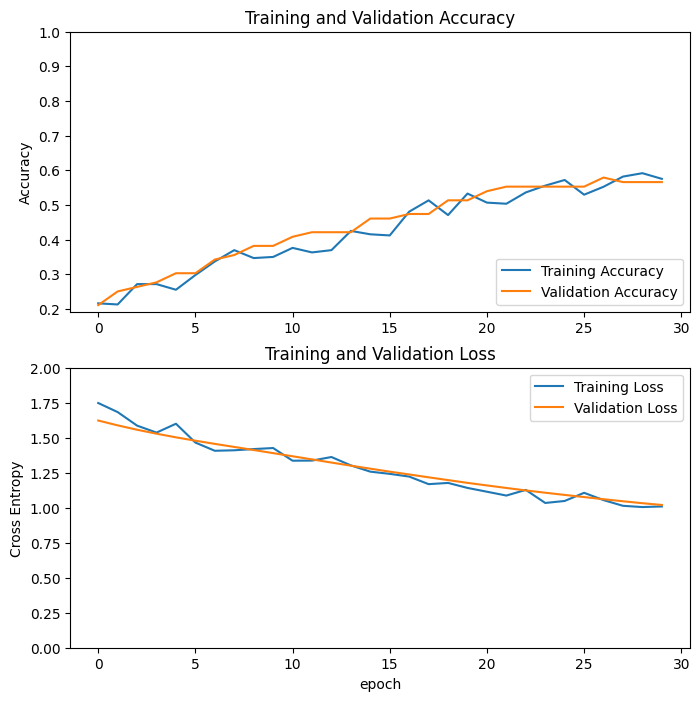

In [12]:
# show the values after the first training of the model in a diagram.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
# Unfreeze the frosen part of the MobileNet.

base_model.trainable = True

In [14]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [15]:
# Optimize
# Compile defines the loss function, the optimizer and the metrics
# Cross-entropy loss is used when adjusting model weights during training. The aim is to minimize the loss

modelX.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

modelX.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124  

In [16]:
#vanaf 100 dus 100 ook en 154 ook

len(modelX.trainable_variables)

56

In [17]:
# Continue training the model.

fine_tune_epochs = 8
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = modelX.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 30/38
3/3 [==============================] - 9s 2s/step - loss: 0.9254 - accuracy: 0.6013 - val_loss: 0.8040 - val_accuracy: 0.6184
Epoch 31/38
3/3 [==============================] - 7s 2s/step - loss: 0.6970 - accuracy: 0.7418 - val_loss: 0.7005 - val_accuracy: 0.7237
Epoch 32/38
3/3 [==============================] - 7s 2s/step - loss: 0.5361 - accuracy: 0.8170 - val_loss: 0.6286 - val_accuracy: 0.7895
Epoch 33/38
3/3 [==============================] - 7s 2s/step - loss: 0.5268 - accuracy: 0.7941 - val_loss: 0.6294 - val_accuracy: 0.7632
Epoch 34/38
3/3 [==============================] - 7s 2s/step - loss: 0.4582 - accuracy: 0.8660 - val_loss: 0.6038 - val_accuracy: 0.7632
Epoch 35/38
3/3 [==============================] - 7s 2s/step - loss: 0.4276 - accuracy: 0.8856 - val_loss: 0.5381 - val_accuracy: 0.8158
Epoch 36/38
3/3 [==============================] - 7s 2s/step - loss: 0.3538 - accuracy: 0.8922 - val_loss: 0.5071 - val_accuracy: 0.8289
Epoch 37/38
3/3 [=================

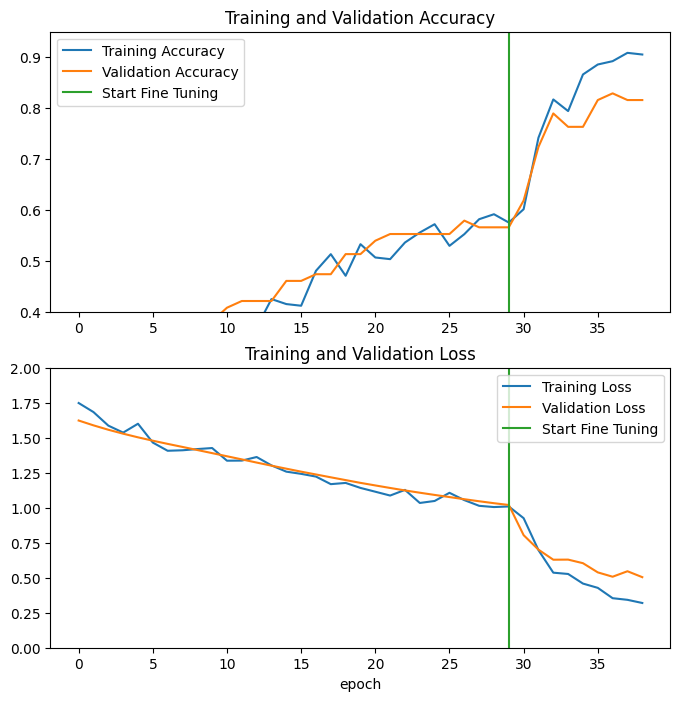

In [18]:
# show the values after the second training of the model in a diagram.

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 0.95])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
#Evaluate the model.

modelX.evaluate(train_ds)

3/3 [==============================] - 4s 1s/step - loss: 0.2206 - accuracy: 0.9673


[0.22060705721378326, 0.9673202633857727]

Found 120 files belonging to 4 classes.


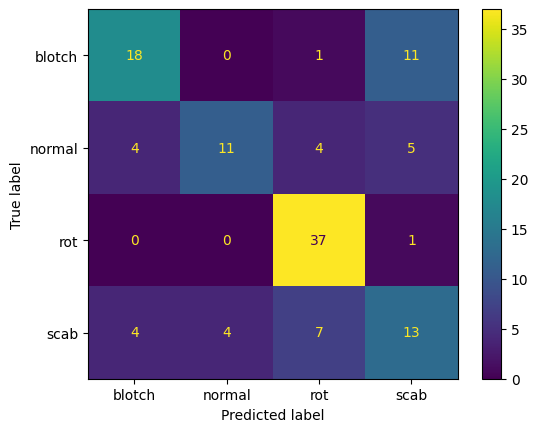

In [20]:
# Make a Confusion matrix to show the labels and prediction

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

data_dir = 'test'

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, seed=123, image_size=(224, 224),shuffle = False, batch_size=120)

batchPredictions = modelX.predict(test_ds)

predicted_categories = tf.argmax(batchPredictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0)

cm = confusion_matrix(true_categories, predicted_categories)

cmd = ConfusionMatrixDisplay(cm, display_labels=['blotch','normal','rot','scab'])

cmd.plot()

In [21]:
# Save the model.
modelX.save('models/mobilenetv2')

INFO:tensorflow:Assets written to: models/mobilenetv2\assets


In [22]:
#show the predictions of the batch.

batchPredictions = modelX.predict(apple_ds)

predicted_categories = tf.argmax(batchPredictions, axis=1)
print(predicted_categories)

tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1], shape=(80,), dtype=int64)


In [23]:
# Make a list from the outcome and print them.

predicted_categories[0]
predicted_categories[0].numpy().tolist()
samplebatchnp = predicted_categories.numpy()
samplebatchlist = samplebatchnp.tolist()
print(samplebatchlist)
print(samplebatchlist.count(0))
print(samplebatchlist.count(1))
print(samplebatchlist.count(2))
print(samplebatchlist.count(3))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
2
77
1
0


In [24]:
# Eventualy made for choosing random 80 Apples from the databatch. 
# Later we made a batch of 80 apples so it won't do anything when the batch consists 80 images.

aqlset_list =(random.choices(samplebatchlist,k = 80))
print(aqlset_list)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


In [25]:
# AQL tester.

blotchApple = aqlset_list.count(0)
HealtyApple = aqlset_list.count(1)
rotApple = aqlset_list.count(2)
scabApple = aqlset_list.count(3)

def AQLTestscore():

    for apple in aqlset_list:
        
        if HealtyApple >=79:
            print (f'The batch has been quallified as: Class 1\n')
        elif HealtyApple >=75:
            print (f'The batch has been quallified as: Class 2\n')
        elif HealtyApple >=73:
            print (f'The batch has been quallified as: Class 3\n')
        else:
            print (f'The batch has been rejected\n')

        print (f'The total batch of {len(aqlset_list)} apples consists of:\n'
        f'Healthy apples: {HealtyApple}\n'
        f'Blotch apples: {blotchApple}\n'
        f'Rot apples: {rotApple}\n'
        f'Scab apples: {scabApple}\n')
        break
    
AQLTestscore()

The batch has been quallified as: Class 3

The total batch of 80 apples consists of:
Healthy apples: 74
Blotch apples: 4
Rot apples: 2
Scab apples: 0



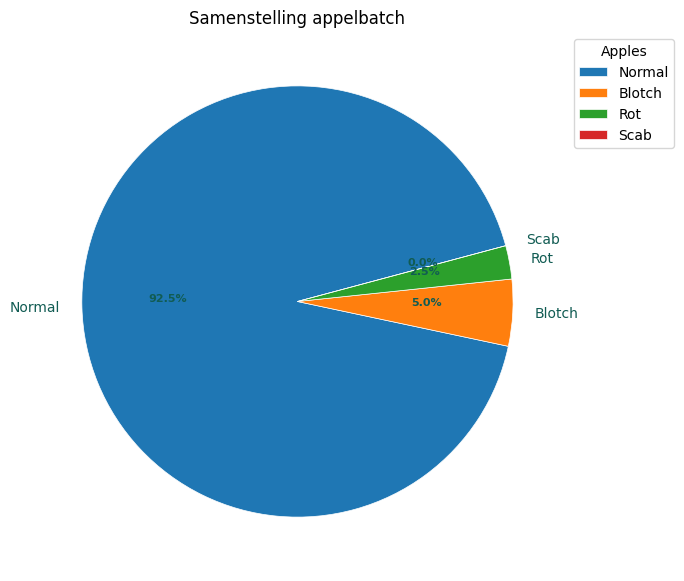

In [26]:
# Show the values in a wedge Diagram.
appleLabels = ['Normal', 'Blotch', 'Rot', 'Scab']
 
data = [HealtyApple, blotchApple, rotApple, scabApple]

# Creating explode data
explode = (0.0, 0.0, 0.0, 0.0) # not necessary

# Wedge properties
wp = { 'linewidth' : 0.5, 'edgecolor' : "white" }

# Creating autocpt arguments
def func(pct, allvalues):
	absolute = int(pct / 100.*np.sum(allvalues))
	return "{:.1f}%\n".format(pct, absolute)

# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(data,
								autopct = lambda pct: func(pct, data),
								explode = explode,
								labels = appleLabels,
								shadow = False,
								startangle = 15,
								wedgeprops = wp,
								textprops = dict(color ="#115C53"))

# Adding legend
ax.legend(wedges, appleLabels,
		title ="Apples",
		loc ="upper left",
		bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Samenstelling appelbatch") # add Classification as title

#show plot
plt.show() 

In [27]:
# SentenceTransformers is a Python framework for state-of-the-art sentence, text and image embeddings.
# Choosen model
# all-MiniLM-L12-v2 	68.70 Performance sentence.
#                   	50.82	Performance semantic.
#                     59.76	Average performance.
#                     7500	Speed.
#                     120 MB Modelsize.


from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L12-v2')


accuracyBatch = modelX.evaluate(apple_ds)

sentences = [f'There are {HealtyApple} healthy apples in this batch',
                                  f'The accuracy of this prediction is {accuracyBatch} for loss and accuracyS',
                                  f'This batch contains {rotApple} rotten apple(s)',
                                  f'This batch contains {scabApple} scabbed apple(s)',
                                  f'This batch contains {blotchApple} blotched apple(s)',
                                    'Class 1 are 79 healty apples for example supermarkets ore greengrocer',
                                    'Class 2 are 75 healty apples used for exapmle in applesause',
                                    'Class 3 are 73 healty apples used for syrup',
                                    'A rejected batch can be used for petfood',
                                    'We have 4 types of apples, Blotch, Normal, Rot and Scab',
                                    'A batch consists of 80 apples',
                                    'Am I so smart ore are you so dum',
                                    'AQL means Acceptance Quality limit',
                                    'The lot size is between 5.000 and 10.000 apples']


query_embedding = model.encode(input('what is your question?'), convert_to_tensor=True)
passage_embedding = model.encode(sentences, convert_to_tensor=True)
answerArray = util.dot_score(query_embedding, passage_embedding)

print("Similarity:", answerArray)

answerLocation = answerArray.argmax()

print(sentences[answerLocation.item()])

3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Similarity: tensor([[0.6441, 0.0784, 0.5095, 0.4727, 0.5731, 0.5502, 0.5703, 0.4701, 0.1672,
         0.5276, 0.6193, 0.2210, 0.1427, 0.8202]])
The lot size is between 5.000 and 10.000 apples
